In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.preprocessing import RobustScaler

In [2]:
df = pd.read_csv('./data/whole_data_practice3.csv')
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (16, 12)

In [3]:
print(df['present'].value_counts()) # датасет не сбалансирован
print(df['type'].isnull().sum() / df.shape[0]) # только 10% заполнено
df.drop('type', inplace=True, axis=1)

present
0    58404
1     6584
Name: count, dtype: int64
0.8997199482981474


In [4]:
print(df.isnull().sum())
df.drop(df.index[:5], inplace=True) # в первых четырех строчках отсутствуют параметры min_mag и max_mag

RAJ2000    0
DEJ2000    0
nobs       0
Vmag       0
e_Vmag     0
Bmag       0
e_Bmag     0
gpmag      0
e_gpmag    0
rpmag      0
e_rpmag    0
ipmag      0
e_ipmag    0
fuv_mag    0
nuv_mag    0
err        0
present    0
min_mag    4
max_mag    4
dtype: int64


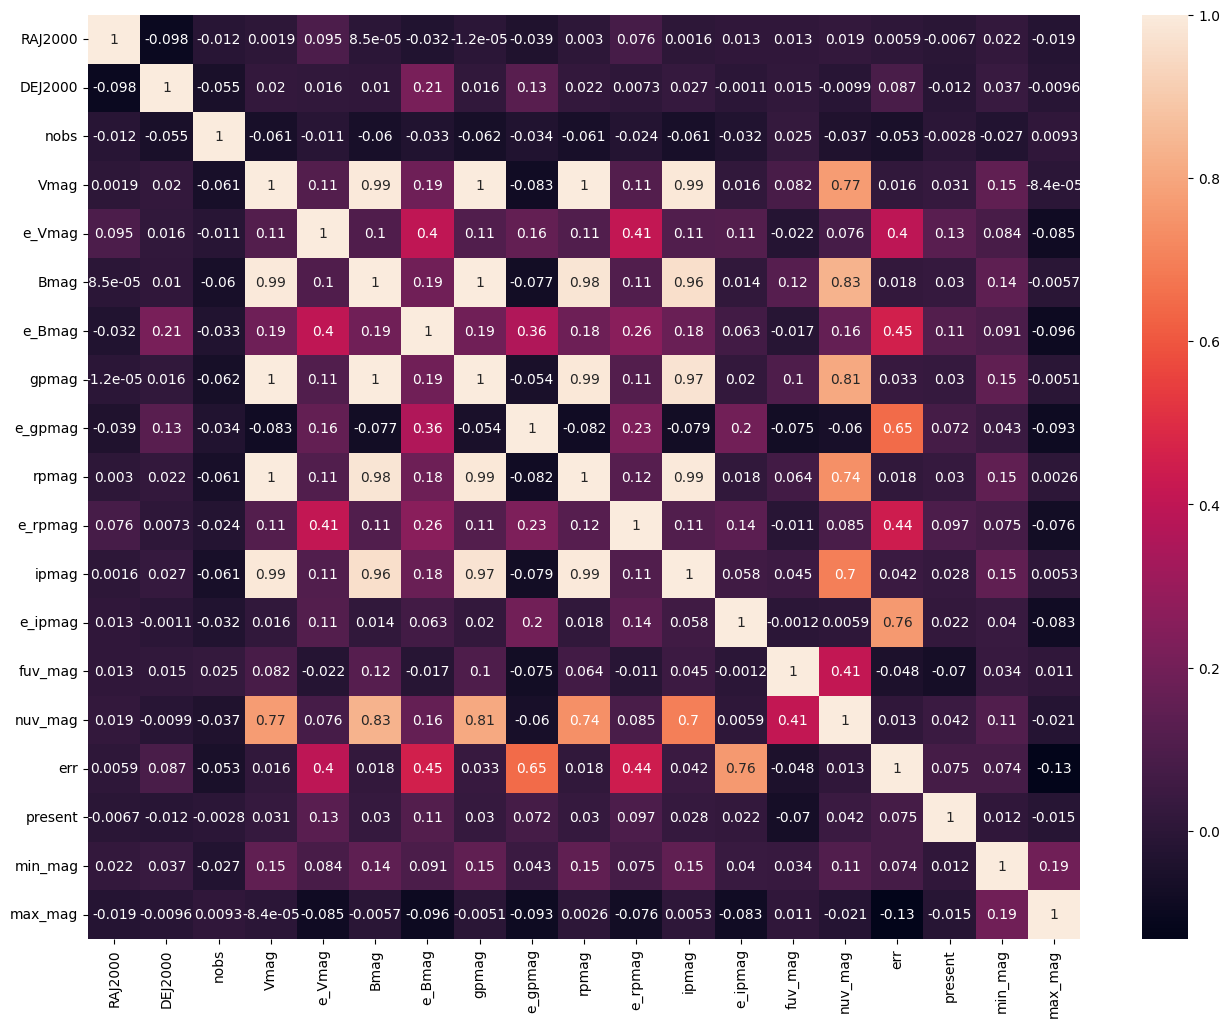

In [5]:
# нарисуем несколько красивых графиков

# корреляция
plt.figure()
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show() # можем удалить Bmag, gpmag, rpmag, ipmag, потому что они коррелируют с Vmag

df.drop(['Bmag', 'gpmag', 'rpmag', 'ipmag'], inplace=True, axis=1)

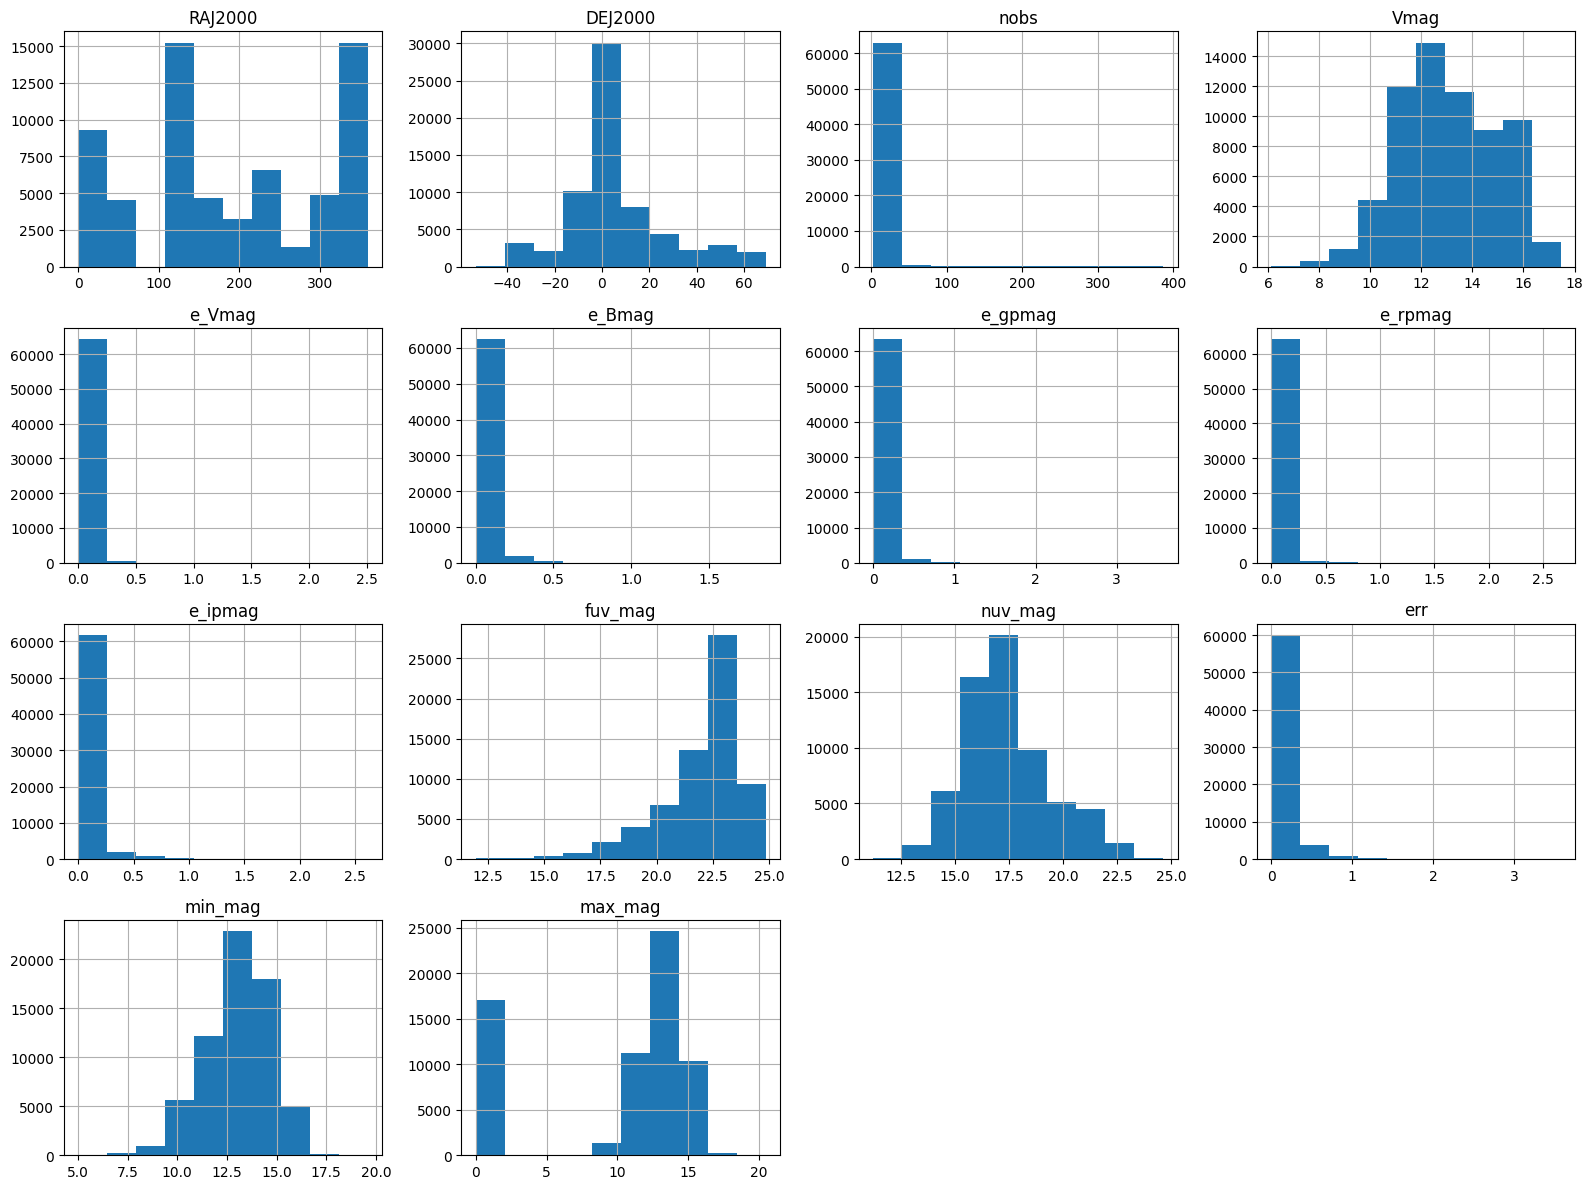

In [6]:
# гистограмма

df.drop(['present'], axis=1).hist()
plt.tight_layout()
plt.show()

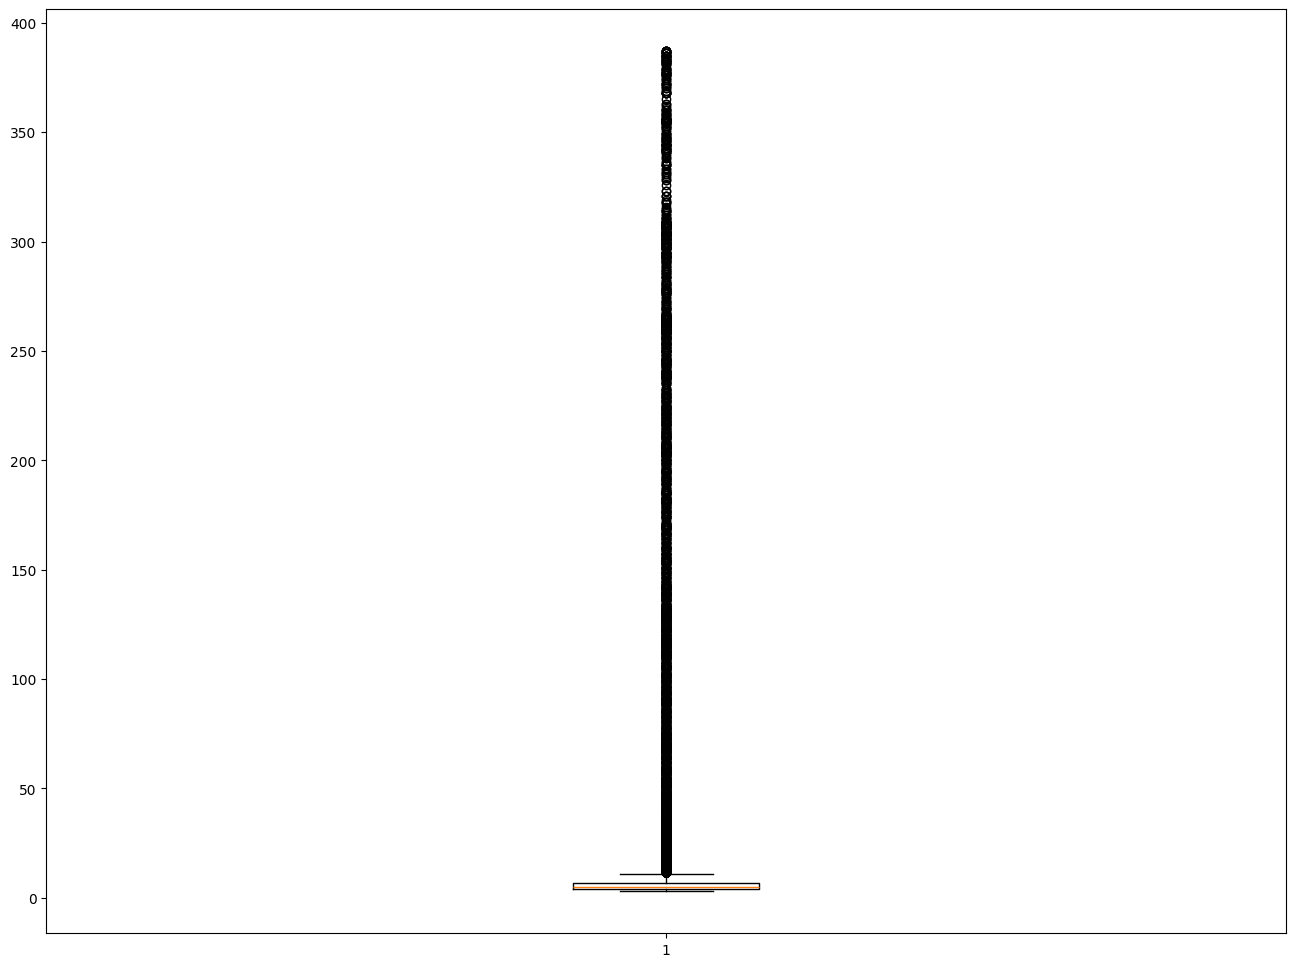

In [7]:
plt.figure()
plt.boxplot(df['nobs'])
plt.show() # большинство значений < 30, но некоторые - очень большие

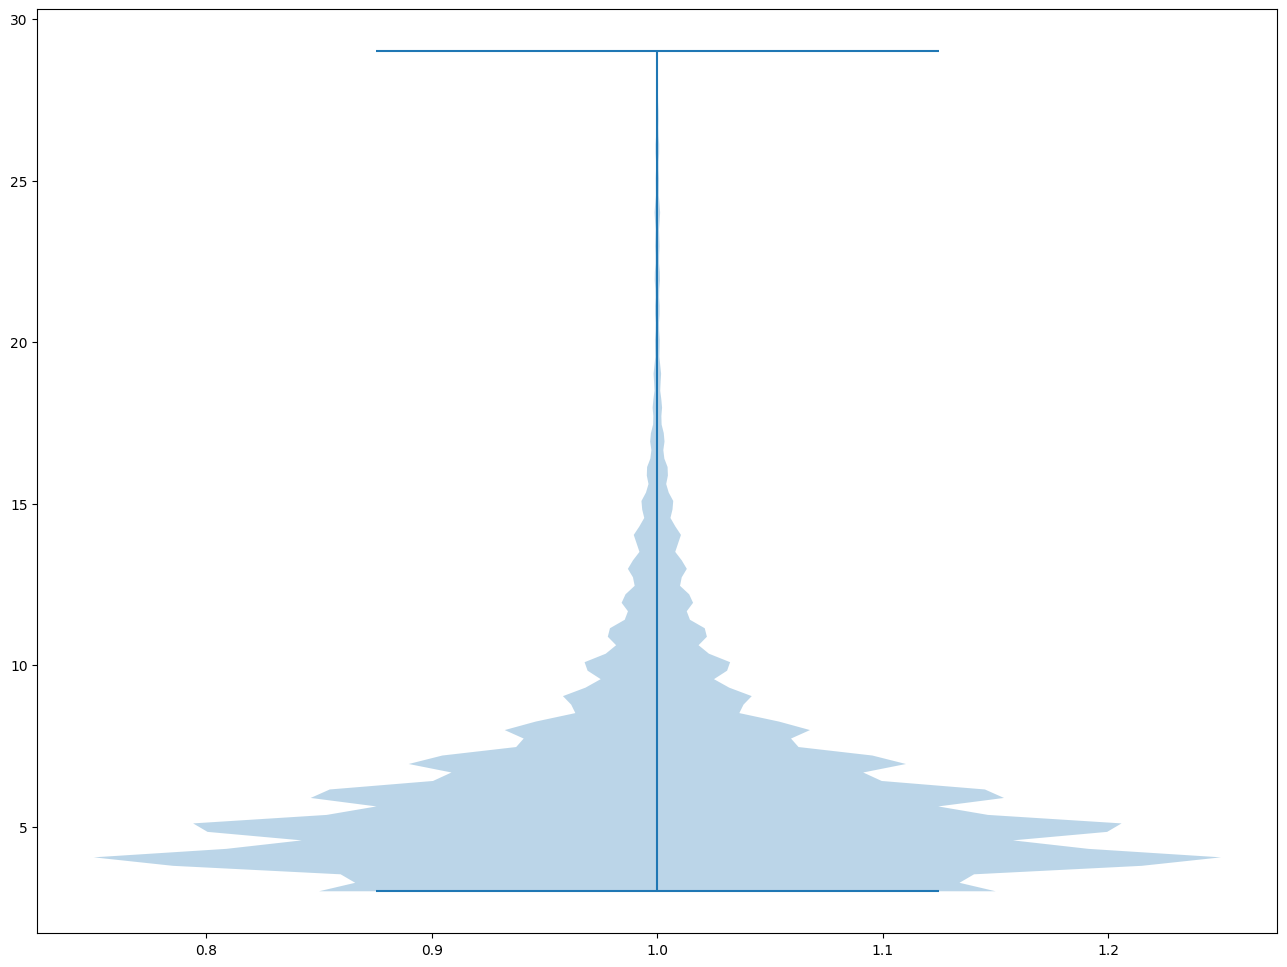

In [8]:
plt.figure()
plt.violinplot(df[df['nobs'] < 30]['nobs'])
plt.show() # большая часть значений близка к нулю и меньше 10

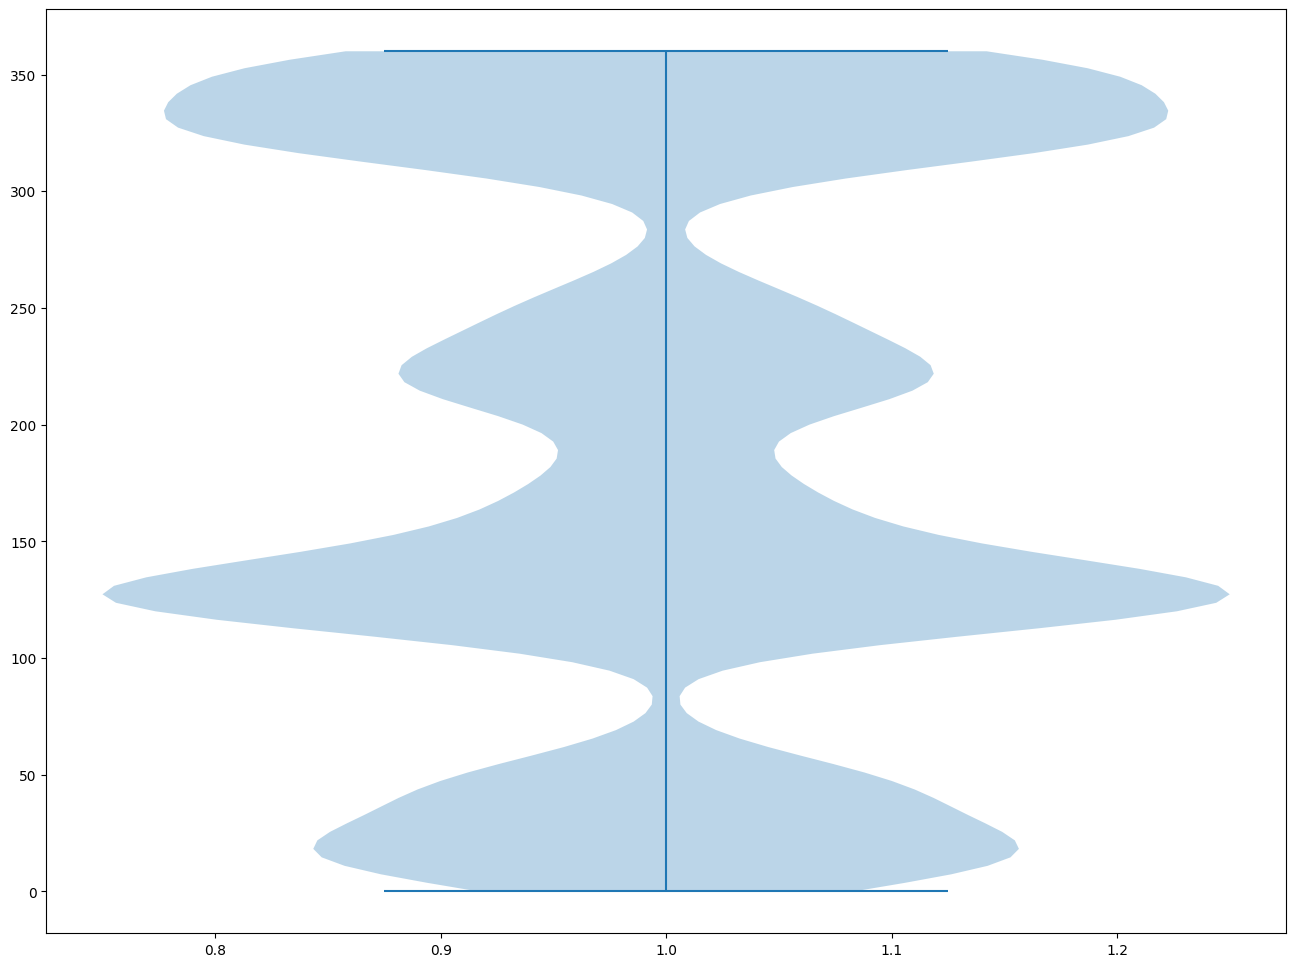

In [9]:
plt.figure()
plt.violinplot(df['RAJ2000'])
plt.show() # интересное распределение

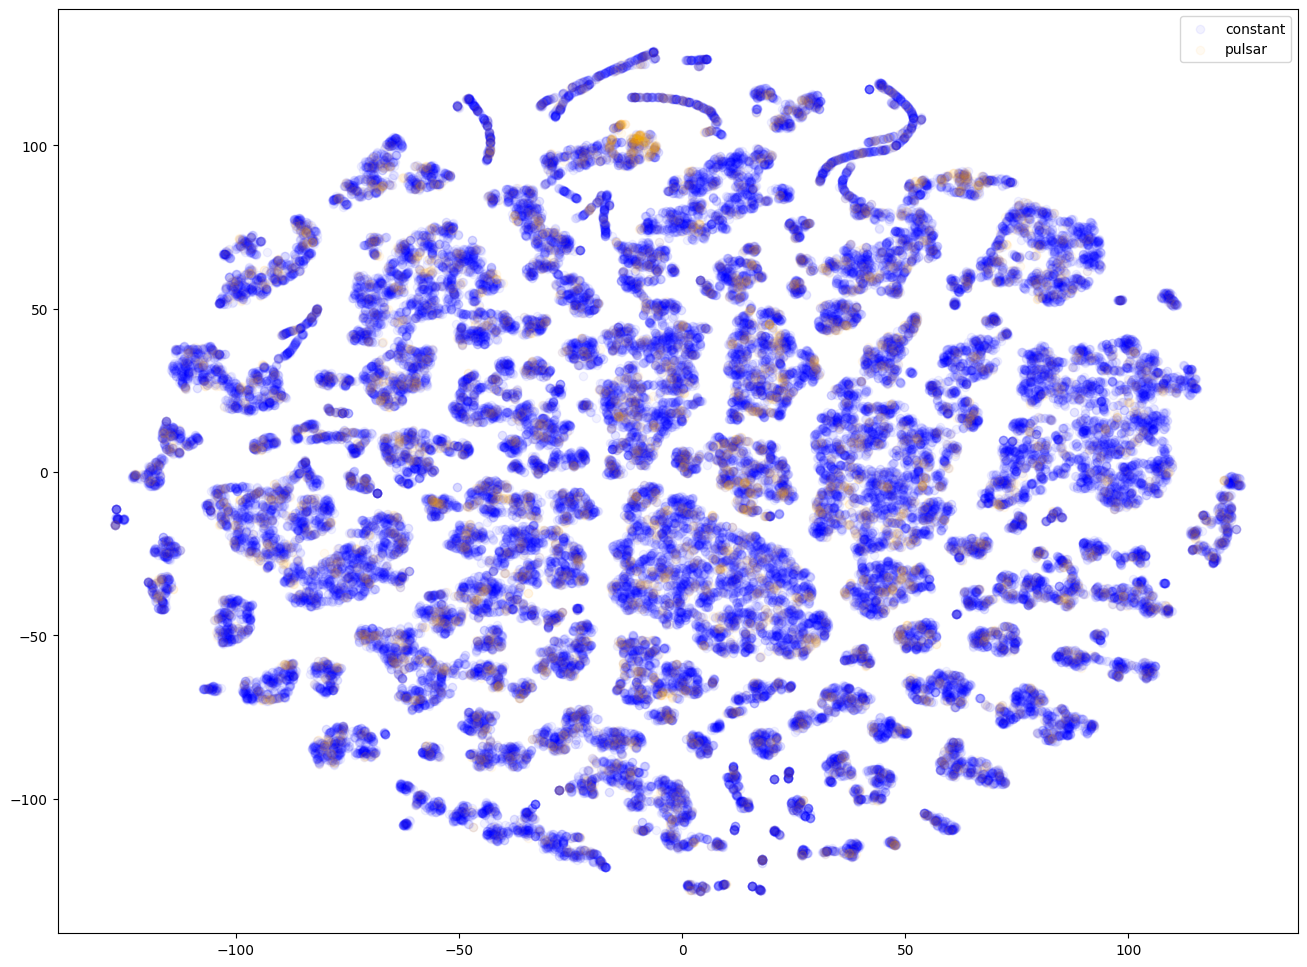

In [10]:
# последний график, честно

plt.figure()
tsne = TSNE(random_state=42)
X_repr = tsne.fit_transform(df)
plt.scatter(X_repr[df['present']==0, 0],
            X_repr[df['present']==0, 1], alpha=.05, c='blue',
           label='constant')
plt.scatter(X_repr[df['present']==1, 0],
            X_repr[df['present']==1, 1], alpha=.05, c='orange',
           label='pulsar')
plt.legend()
plt.show()

In [11]:
# поехали

def count_metrics(y, y_pred, method): # вычисление метрик, вывод, построение матрицы ошибок

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)


    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

    # confusion matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Матрица ошибок: {method}')
    plt.show()

Accuracy: 0.6620
Precision: 0.1568
Recall: 0.5336
F1-score: 0.2423


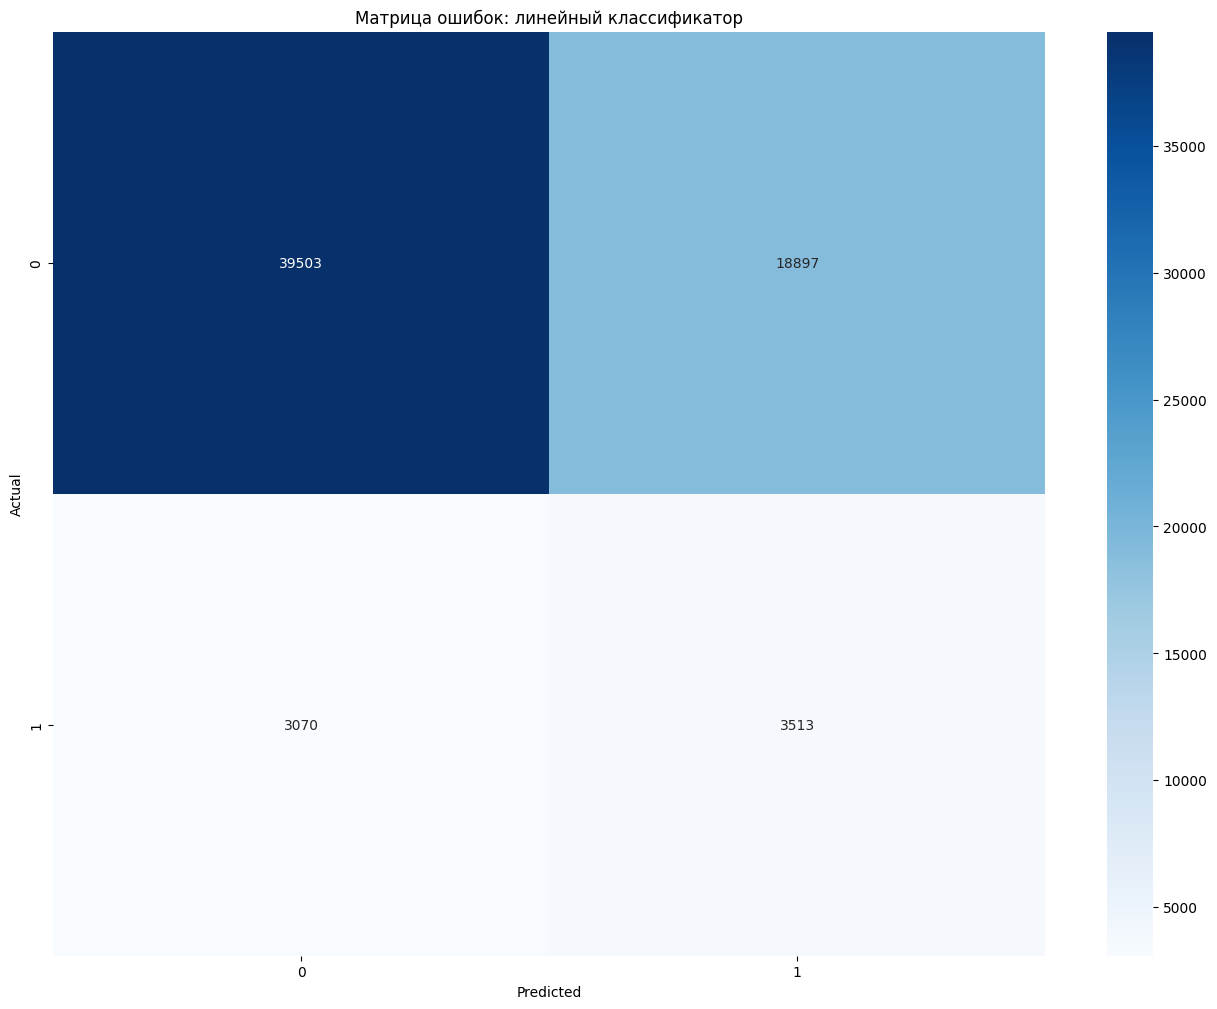

In [12]:
# линейный классификатор

from sklearn.linear_model import LogisticRegression

X = df[[x for x in df.columns if x != 'present']]
y = df['present']

# масштабируем данные - используем RobustScaler, так как он наиболее устойчив к выбросам
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

lr = LogisticRegression(max_iter=300, class_weight='balanced')

# cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(lr, X_scaled, y, cv=cv)


count_metrics(y, y_pred, 'линейный классификатор')

Accuracy: 0.9010
Precision: 0.5204
Recall: 0.2850
F1-score: 0.3683


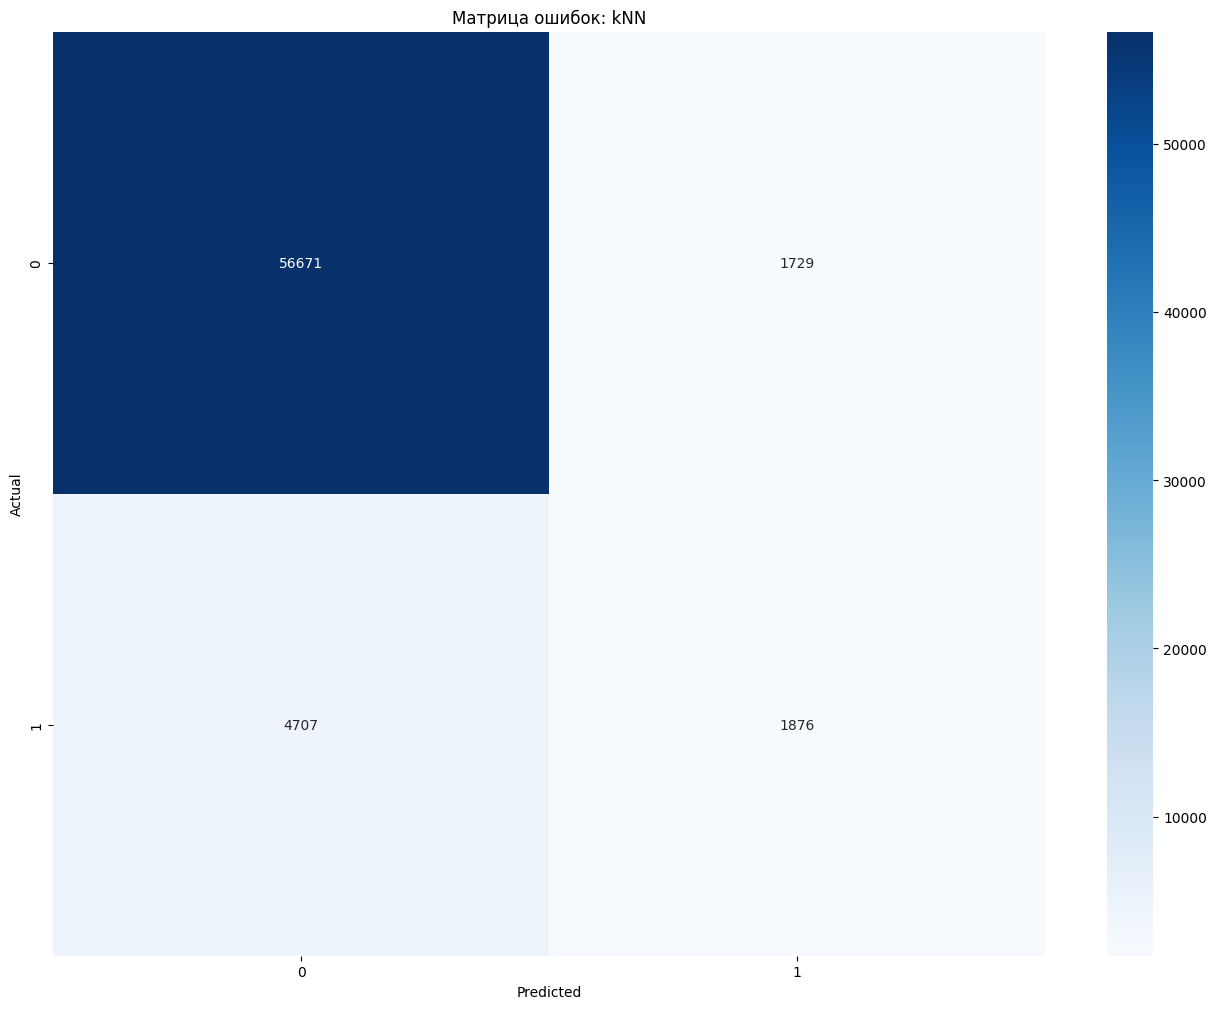

In [13]:
# kNN, плохо подходит для несбалансированного датасета

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')

y_pred = cross_val_predict(knn, X_scaled, y, cv=cv)

count_metrics(y, y_pred, 'kNN') # ожидаемо, метрики - плохие

Accuracy: 0.9064
Precision: 0.5384
Recall: 0.5303
F1-score: 0.5343


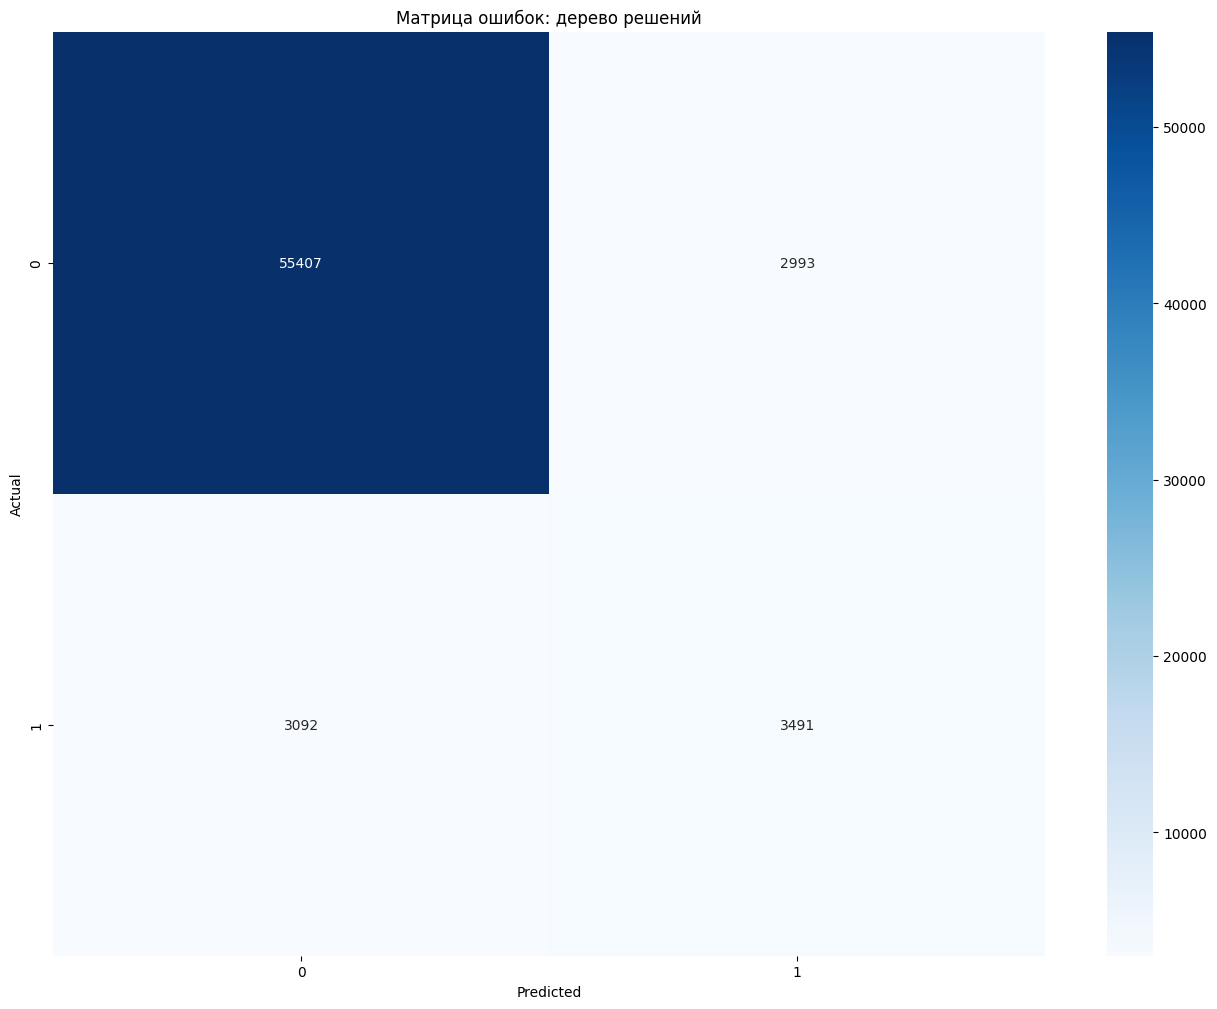

In [14]:
# дерево решений

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion="entropy", class_weight='balanced')

y_pred = cross_val_predict(tree, X_scaled, y, cv=cv)

count_metrics(y, y_pred, 'дерево решений')

Accuracy: 0.9231
Precision: 0.8956
Recall: 0.2722
F1-score: 0.4175


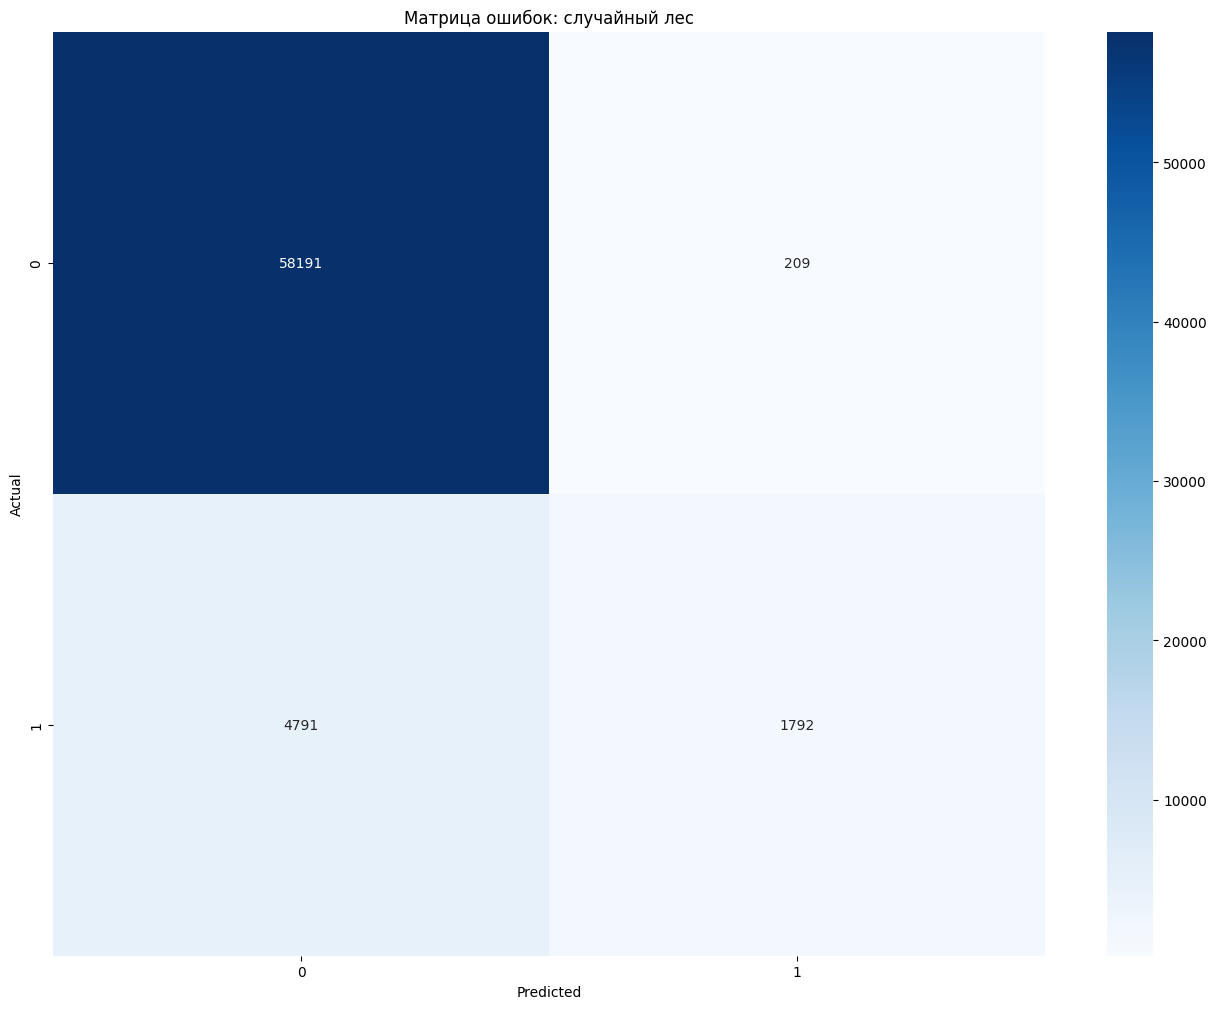

In [15]:
# случайный лес без дополнительных параметров - интересно, что accuracy и precision выросли, но recall и F1 сильно упали

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight='balanced')

y_pred = cross_val_predict(rfc, X_scaled, y, cv=cv)

count_metrics(y, y_pred, 'случайный лес')

Accuracy: 0.9110
Precision: 0.8653
Recall: 0.1434
F1-score: 0.2460


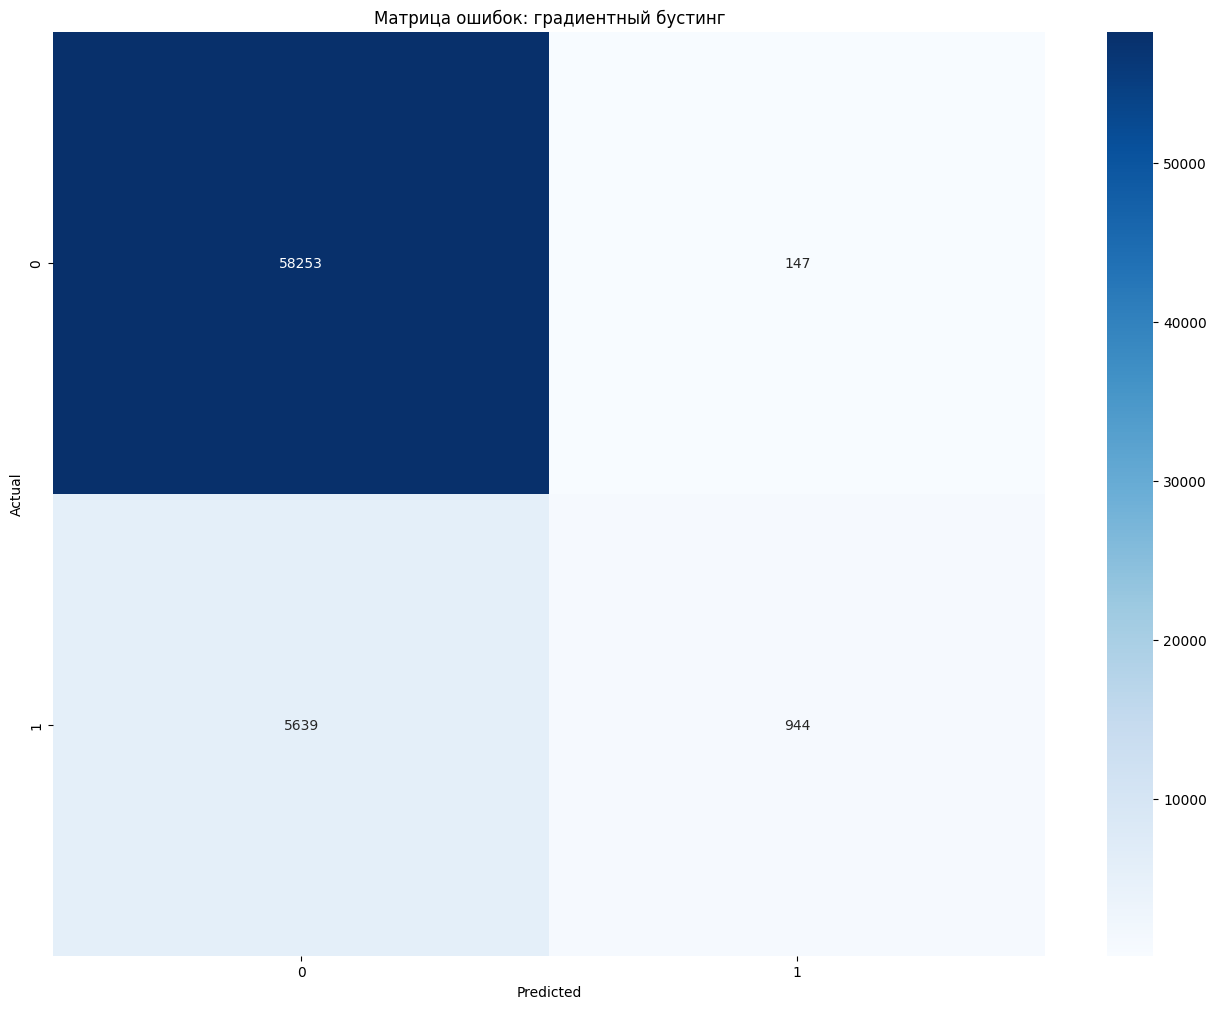

In [16]:
# градиентный бустинг - внезапно, очень низкий recall!
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

y_pred = cross_val_predict(gb, X_scaled, y, cv=cv)

count_metrics(y, y_pred, 'градиентный бустинг')

Accuracy: 0.8655
Precision: 0.4085
Recall: 0.7310
F1-score: 0.5241


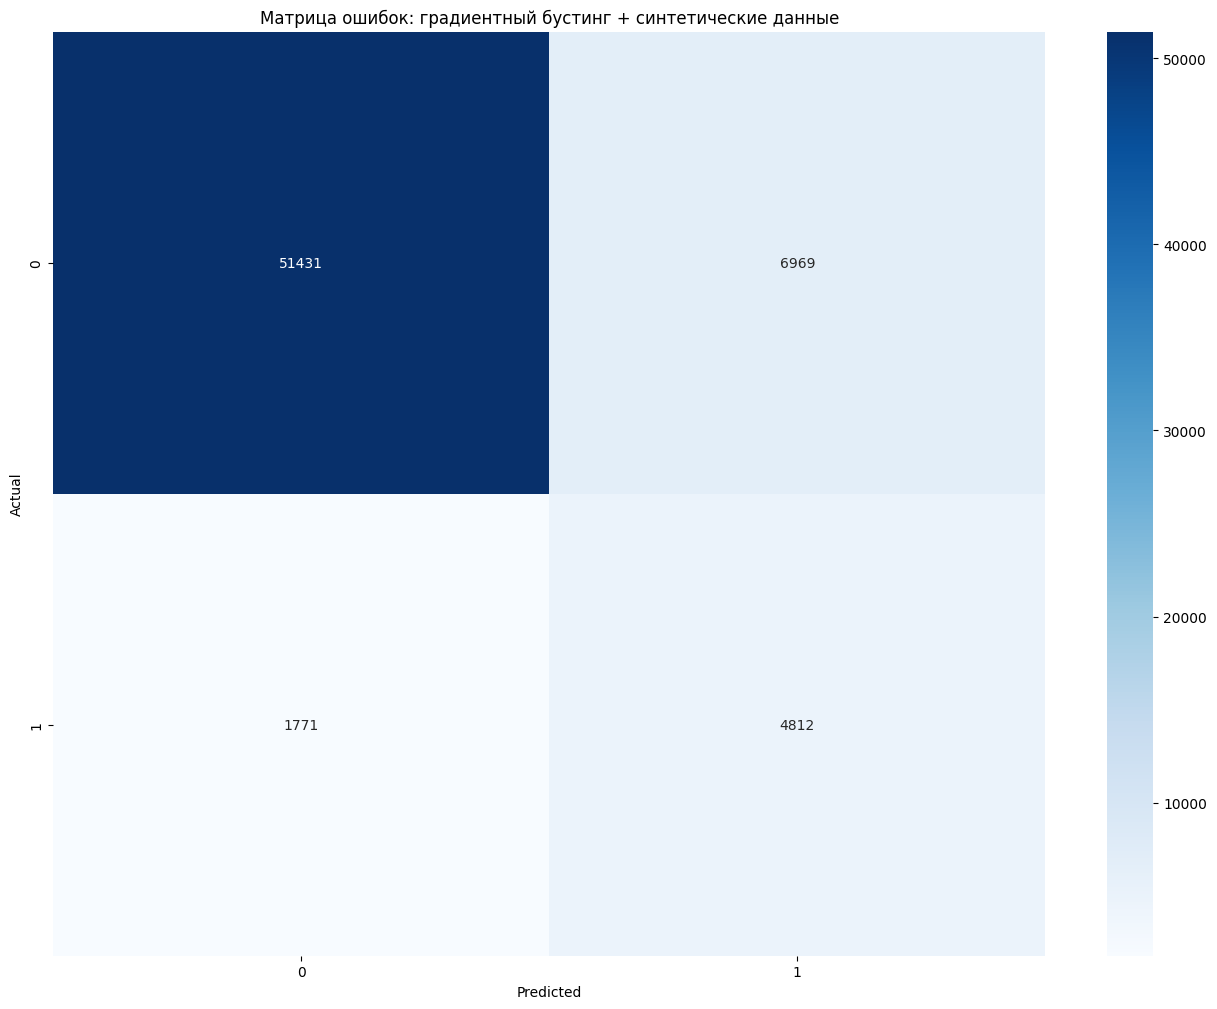

In [17]:
# попробуем дополнить датасет синтетическими данными (oversampling)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("gb", GradientBoostingClassifier())
])

gb = GradientBoostingClassifier()
y_pred = cross_val_predict(pipeline, X_scaled, y, cv=cv)

count_metrics(y, y_pred, method='градиентный бустинг + синтетические данные') # резко возросли recall и f1

In [18]:
# подберем оптимальные параметры
from sklearn.model_selection import GridSearchCV

params = {
    "smote__k_neighbors": [3, 5],
    "gb__max_depth": [7, 10, 12],
}

grid_search = GridSearchCV(pipeline, params, scoring="recall", cv=cv, n_jobs=-1)
grid_search.fit(X_scaled, y)

print("Лучшие параметры:", grid_search.best_params_) # max_depth=10, k_neighbors=5

Лучшие параметры: {'gb__max_depth': 7, 'smote__k_neighbors': 3}


Accuracy: 0.9234
Precision: 0.5934
Recall: 0.7738
F1-score: 0.6717


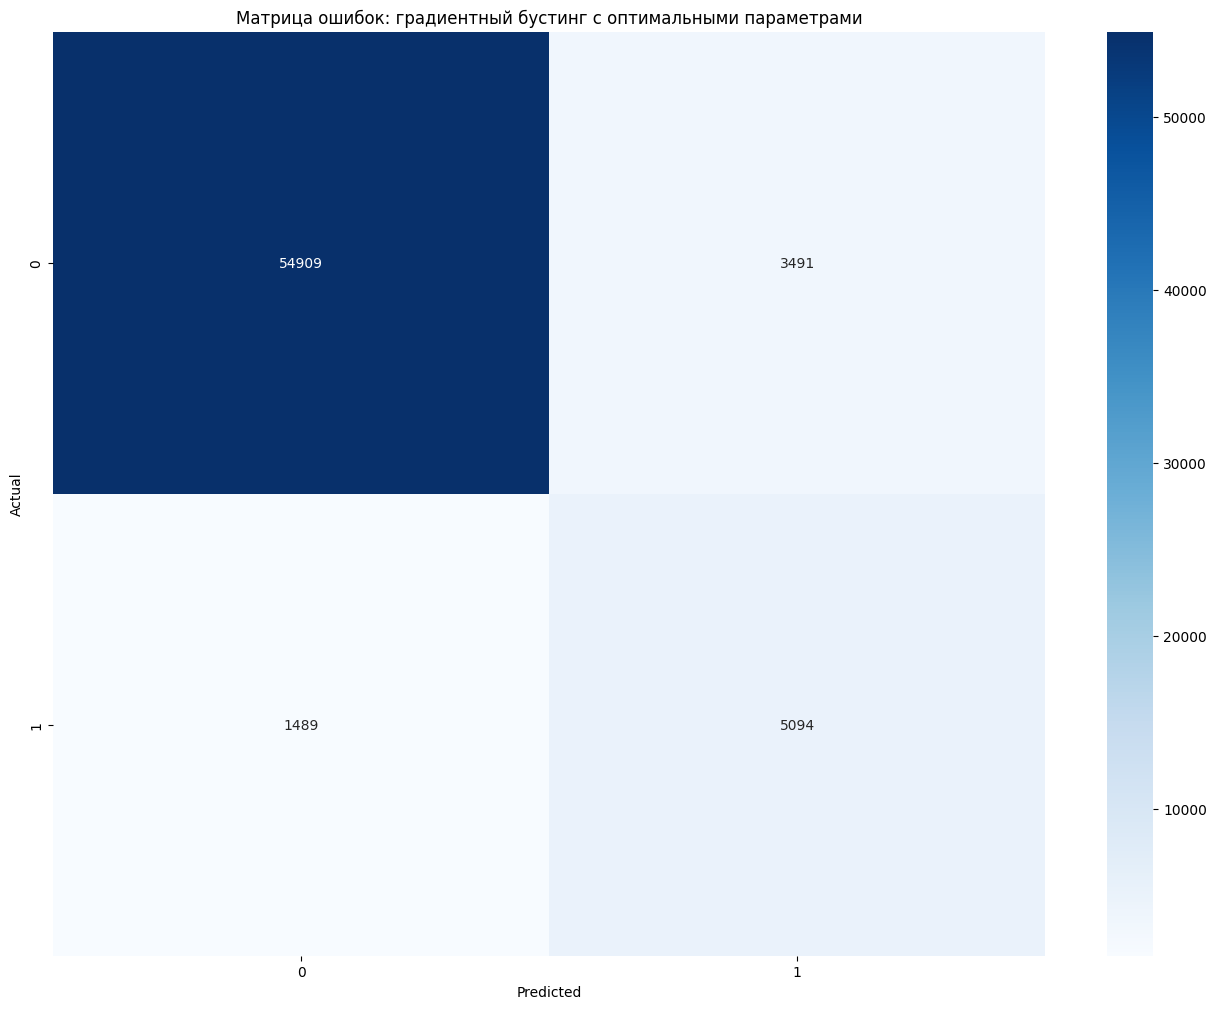

In [19]:
# обучим модель на полученных параметрах
best_model = grid_search.best_estimator_

y_pred = cross_val_predict(best_model, X_scaled, y, cv=cv)
count_metrics(y, y_pred, 'градиентный бустинг с оптимальными параметрами')

In [20]:
# стэкинг бустингов

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

In [21]:
# используем разбиение на train и test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

In [22]:
# SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [25]:
# модели, которые используются в стекинге: различные реализации бустингов
base_estimators = [
    ('catboost', CatBoostClassifier(
        verbose=False, random_state=42
    )),
    ('gbc', GradientBoostingClassifier(
        random_state=42
    )),
    ('xgb', XGBClassifier(
        eval_metric='logloss', random_state=42
    )),
    ('lgbm', LGBMClassifier(
        random_state=42, verbosity = -1
    )),
]

In [26]:
# мета-классификатор - линейная регрессия
final_est = LogisticRegression(
    solver='lbfgs',
    random_state=42
)

In [27]:
# стекинг
stack = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_est,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stack.fit(X_res, y_res)

StackingClassifier(cv=5,
                   estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x799b94092cc0>),
                               ('gbc',
                                GradientBoostingClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=Fa...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('lgbm',
                                LGBMClassifier(random_state=42, verbosity=-1))],
                   final_estimator=LogisticRegression(random_state=42),
                   n_jobs=-1)

In [28]:
# найдем идеальный порог уверенности модели, выше которого будем присваивать класс 1
y_proba = stack.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# используем precision_recall_curve, чтобы определить такой threshold, что precision остается >=.65, а recall - максимальный
best_threshold = 0.5
best_recall = 0
for i, threshold in enumerate(thresholds):
    if precisions[i] >= 0.65 and recalls[i] > best_recall:
        best_recall = recalls[i]
        best_threshold = threshold

y_pred = (y_proba >= best_threshold).astype(int)
print(f"Оптимальный порог: {best_threshold:.3f}")

Оптимальный порог: 0.471


Accuracy: 0.9383
Precision: 0.6503
Recall: 0.8459
F1-score: 0.7353


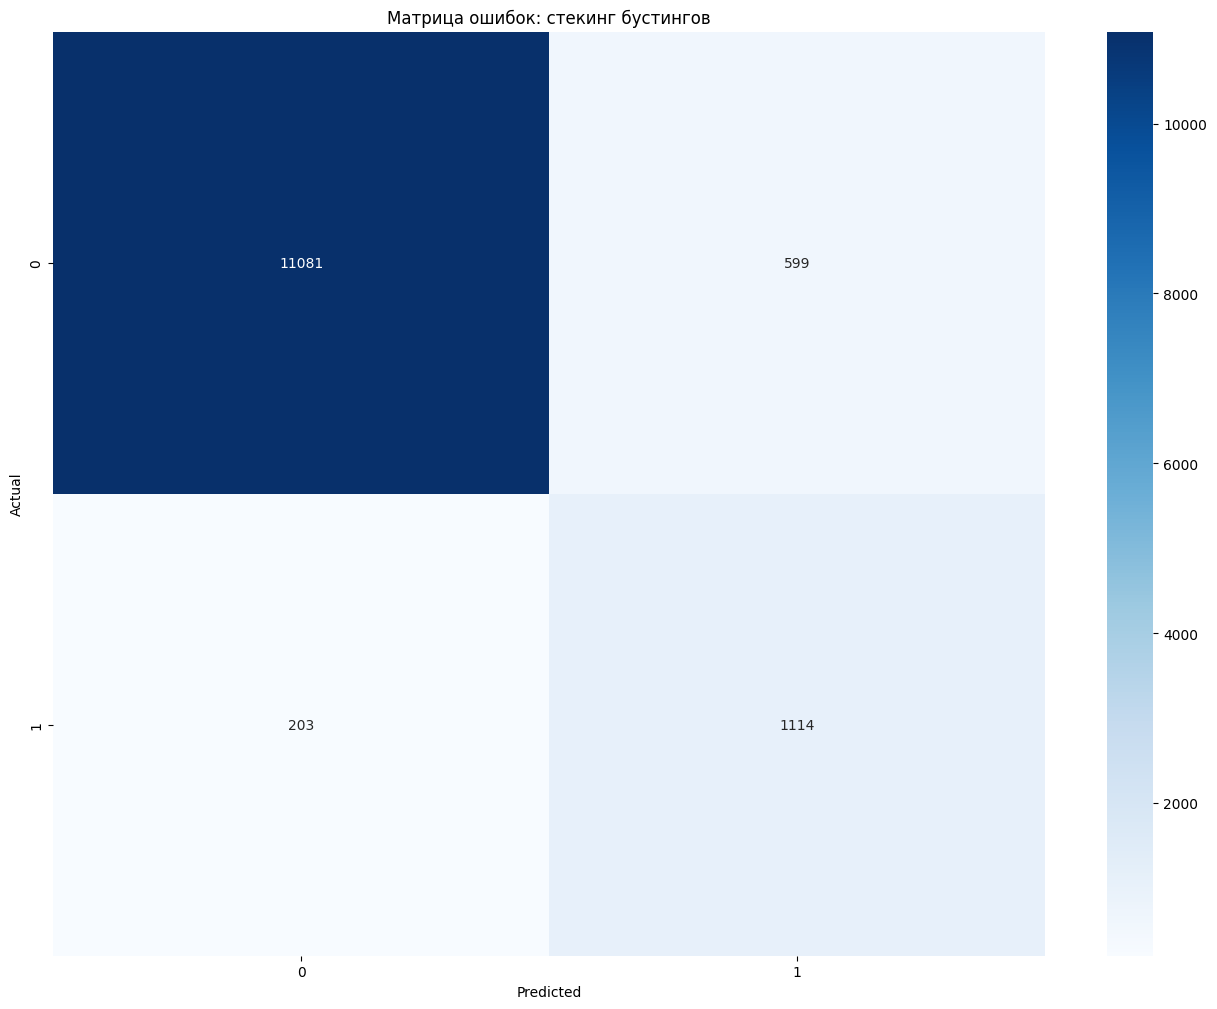

In [29]:
count_metrics(y_test, y_pred, 'стекинг бустингов') #.93, .65, .8, .72